## Classify eGFP vs. negcons

In [13]:
import pandas as pd

In [14]:
profiles = pd.read_parquet("../1.load/output/raw_filtered_profiles_with_poscon.parquet")
profiles.head()

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7


In [15]:
profiles.shape

(81490, 4780)

In [16]:
# select only poscons and negcons

selected_negcons = ["BFP", "HcRed", "LUCIFERASE", "LacZ"]
selected_poscons = ["eGFP"]
profiles["Metadata_SymbolX"] = profiles.Metadata_Symbol
profiles.loc[
    profiles.Metadata_Symbol.isin(selected_poscons), "Metadata_SymbolX"
] = "poscon"
profiles.loc[
    profiles.Metadata_Symbol.isin(selected_negcons), "Metadata_SymbolX"
] = "negcon"

# drop rows where Metadata_SymbolX is neither poscon nor negcon

profiles = profiles.loc[
    profiles.Metadata_SymbolX.isin(["poscon", "negcon"]), :
].reset_index(drop=True)


# Now report counts of Metadata_SymbolX

profiles.Metadata_SymbolX.value_counts()

negcon    3680
poscon    1930
Name: Metadata_SymbolX, dtype: int64

In [17]:
# Keep only `Metadata_SymbolX` and columns that start with `Cells_` or `Nuclei_` or `Cytoplasm_` or `Image_`

prefixes = ["Cells_", "Nuclei_", "Cytoplasm_", "Image_"]
profiles = profiles[
    ["Metadata_SymbolX"]
    + [
        col
        for col in profiles.columns
        if any(col.startswith(prefix) for prefix in prefixes)
    ]
]

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Define features and target
X = profiles.drop("Metadata_SymbolX", axis=1)
y = profiles["Metadata_SymbolX"]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
# Use a random forest classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[702  44]
 [ 73 303]]
              precision    recall  f1-score   support

      negcon       0.91      0.94      0.92       746
      poscon       0.87      0.81      0.84       376

    accuracy                           0.90      1122
   macro avg       0.89      0.87      0.88      1122
weighted avg       0.89      0.90      0.89      1122



In [21]:
# Use an xgboost classifier to see if we can do better
# We first need to encode the labels of y

import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

from sklearn import preprocessing

# Assuming your data is already clean
X = profiles.drop("Metadata_SymbolX", axis=1)
y = profiles["Metadata_SymbolX"]

# Encode labels of y
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [200]:
# Train a model to do feature selection; first use just 10 features to see how well it does

selection = SelectFromModel(
    xgb.XGBClassifier(
        n_estimators=100, eval_metric="mlogloss", random_state=42, n_jobs=-1
    ),
    max_features=20,
)
selection.fit(X_train, y_train)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='mlogloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=-1,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=42, ...),
                max_features=20)

In [201]:
# Get a boolean mask of the features selected by the model
selected_features_mask = selection.get_support()

# Apply this mask to the original feature names to get the names of the selected features
selected_features = X_train.columns[selected_features_mask]

selected_features

Index(['Cells_Correlation_Correlation_DNA_ER', 'Cells_Correlation_K_Mito_DNA',
       'Cells_Texture_InfoMeas2_AGP_5_01_256',
       'Cytoplasm_Correlation_K_Mito_AGP',
       'Cytoplasm_Texture_AngularSecondMoment_DNA_3_01_256',
       'Cytoplasm_Texture_InfoMeas1_DNA_10_02_256',
       'Cytoplasm_Texture_InfoMeas2_DNA_10_02_256',
       'Cytoplasm_Texture_InfoMeas2_DNA_3_00_256',
       'Cytoplasm_Texture_InfoMeas2_Mito_3_02_256',
       'Image_Intensity_MeanIntensity_AGP__BackgroundOnly',
       'Image_Texture_Correlation_RNA_3_00_256',
       'Image_Texture_Correlation_RNA_3_01_256',
       'Image_Texture_Correlation_RNA_5_01_256',
       'Image_Texture_InverseDifferenceMoment_DNA_10_01_256',
       'Nuclei_AreaShape_Perimeter', 'Nuclei_Correlation_RWC_RNA_ER',
       'Nuclei_Granularity_11_Mito', 'Nuclei_Texture_Contrast_RNA_3_00_256',
       'Nuclei_Texture_Correlation_RNA_3_01_256',
       'Nuclei_Texture_InfoMeas1_RNA_5_03_256'],
      dtype='object')

In [203]:
# Transform train and test sets
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

# Train the model
clf = xgb.XGBClassifier(
    n_estimators=100, eval_metric="mlogloss", random_state=42, n_jobs=-1
)
clf.fit(select_X_train, y_train)

# Predict the labels
y_pred = clf.predict(select_X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[697  49]
 [ 55 321]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       746
           1       0.87      0.85      0.86       376

    accuracy                           0.91      1122
   macro avg       0.90      0.89      0.90      1122
weighted avg       0.91      0.91      0.91      1122



In [26]:
# Can we improve on it?
# We will use more features and a randomized grid search to find the best classifier and hyperparameters

selection = SelectFromModel(
    xgb.XGBClassifier(
        n_estimators=100, eval_metric="mlogloss", random_state=42, n_jobs=-1
    ),
    threshold="mean",
)
selection.fit(X_train, y_train)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

from sklearn.model_selection import RandomizedSearchCV

# Parameter Tuning
param_dist = {
    "n_estimators": range(80, 200, 20),
    "max_depth": range(2, 10, 1),
    "learning_rate": [0.1, 0.01, 0.05],
}

rsearch = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(eval_metric="mlogloss"),
    param_distributions=param_dist,
    scoring="accuracy",
    cv=5,
    n_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=4,
)
rsearch.fit(select_X_train, y_train)

# Print best parameters
print(rsearch.best_params_)

# Train the model using the best parameters
clf_best = xgb.XGBClassifier(
    n_estimators=rsearch.best_params_["n_estimators"],
    max_depth=rsearch.best_params_["max_depth"],
    learning_rate=rsearch.best_params_["learning_rate"],
    eval_metric="mlogloss",
    random_state=42,
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=100;, score=0.890 total time=  28.1s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=100;, score=0.895 total time=  27.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.941 total time= 1.1min
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.947 total time= 1.1min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.931 total time= 1.1min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.920 total time= 1.1min
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.958 total time= 1.1min
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=100;, score=0.893 total time=  27.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=100;, score=0.873 total time=  26.5s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=100;, score=0.876 tot

In [27]:
clf_best.fit(select_X_train, y_train)

# Predict the labels for the best model
y_pred_best = clf_best.predict(select_X_test)

# Evaluate the best model
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

[[727  19]
 [ 36 340]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       746
           1       0.95      0.90      0.93       376

    accuracy                           0.95      1122
   macro avg       0.95      0.94      0.94      1122
weighted avg       0.95      0.95      0.95      1122



In [137]:
# Get a boolean mask of the features selected
selected_features_mask = selection.get_support()

# Apply this mask to the original feature names to get the names of the selected features
selected_features = X_train.columns[selected_features_mask]

# Get the feature importances for only the selected features
selected_importances = pd.Series(
    clf_best.feature_importances_, index=selected_features
).sort_values(ascending=False)

# Get top features
top_n = 20
top_features = selected_importances[:top_n]

print(top_features)

Cells_Texture_InfoMeas2_AGP_5_01_256                      0.026536
Cytoplasm_Texture_AngularSecondMoment_DNA_3_01_256        0.024780
Image_Texture_Correlation_RNA_3_00_256                    0.024196
Cytoplasm_Texture_InfoMeas1_DNA_5_01_256                  0.022063
Image_Texture_Correlation_RNA_3_01_256                    0.020559
Cytoplasm_Texture_InfoMeas2_DNA_3_00_256                  0.019828
Nuclei_Correlation_RWC_RNA_ER                             0.015286
Image_Texture_InverseDifferenceMoment_DNA_10_01_256       0.014187
Nuclei_Texture_Contrast_RNA_3_00_256                      0.013754
Nuclei_Texture_Correlation_DNA_3_00_256                   0.011409
Cells_Granularity_12_Mito                                 0.010990
Cells_Correlation_Correlation_DNA_ER                      0.010649
Cells_Intensity_IntegratedIntensityEdge_DNA               0.010431
Cells_RadialDistribution_MeanFrac_mito_tubeness_20of20    0.009856
Image_Texture_AngularSecondMoment_AGP_10_01_256           0.00

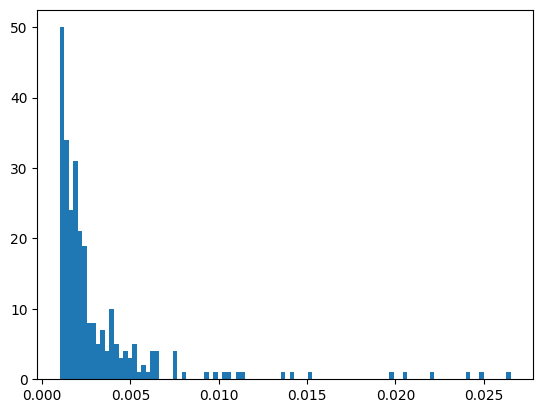

In [38]:
# plot a histogram of clf.feature_importances_

import matplotlib.pyplot as plt

plt.hist(clf_best.feature_importances_[clf_best.feature_importances_ > 0.001], bins=100)
plt.show()

In [196]:
import requests

url = "https://raw.githubusercontent.com/shntnu/pycytominer/parse_cp_features/pycytominer/cyto_utils/parse_cp_features.py"
response = requests.get(url)
exec(response.text)

selected_features_df = selected_importances.reset_index()
selected_features_df.columns = ["feature", "importance"]
selected_features_df_parsed = selected_features_df["feature"].apply(parse_cp_features).apply(pd.Series)  # type: ignore
selected_features_df_parsed = selected_features_df_parsed.join(
    selected_features_df["importance"]
)

# when channel has an underscore then replace the whole string with the word "composite"

selected_features_df_parsed["channel"] = selected_features_df_parsed["channel"].replace(
    ".*_.*", "XCOMPOSITE", regex=True
)

selected_features_df_parsed.sample(100)

,feature,compartment,feature_group,feature_type,channel,importance
154,Cells_Texture_Correlation_AGP_10_01_256,Cells,Texture,Correlation,AGP,0.001864
54,Nuclei_Texture_Contrast_RNA_3_02_256,Nuclei,Texture,Contrast,RNA,0.003979
50,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei,Intensity,IntegratedIntensity,DNA,0.004170
451,Nuclei_AreaShape_MeanRadius,Nuclei,AreaShape,MeanRadius,XNONE,0.000285
111,Nuclei_Intensity_MinIntensity_AGP,Nuclei,Intensity,MinIntensity,AGP,0.002307
...,...,...,...,...,...,...
24,Nuclei_Location_MaxIntensity_Y_Mito,Nuclei,Location,MaxIntensity,MITO,0.006349
266,Cells_Intensity_MassDisplacement_Mito,Cells,Intensity,MassDisplacement,MITO,0.001034
300,Nuclei_RadialDistribution_RadialCV_ER_2of4,Nuclei,RadialDistribution,RadialCV,ER,0.000891
226,Cytoplasm_AreaShape_Zernike_6_2,Cytoplasm,AreaShape,Zernike,XNONE,0.001244


In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

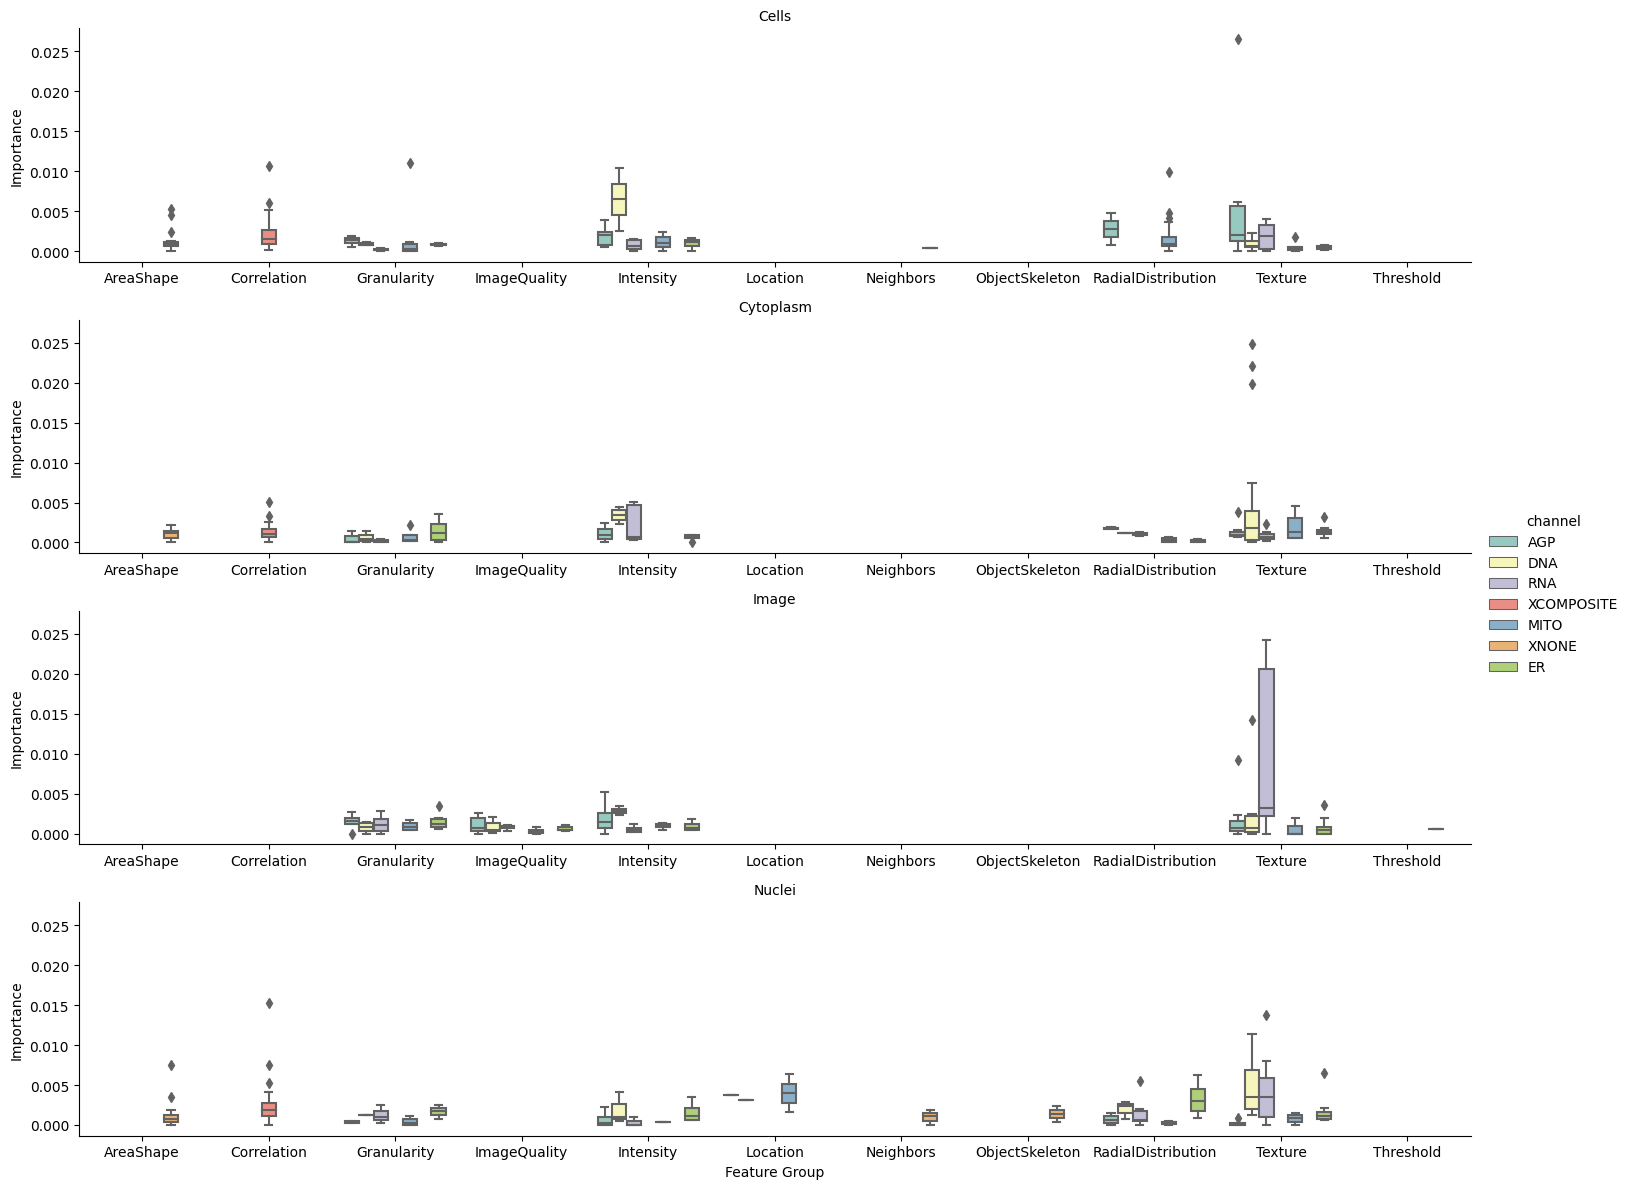

In [198]:
feature_group_order = sorted(selected_features_df_parsed["feature_group"].unique())

g = sns.catplot(
    data=selected_features_df_parsed,
    kind="box",
    x="feature_group",
    y="importance",
    col="compartment",
    hue="channel",
    order=feature_group_order,
    col_wrap=1,
    height=3,
    aspect=5,
    sharex=False,
    palette="Set3",  # Optional: specify a color palette
)
g.set_axis_labels("Feature Group", "Importance")
g.set_titles("{col_name}")

plt.show()

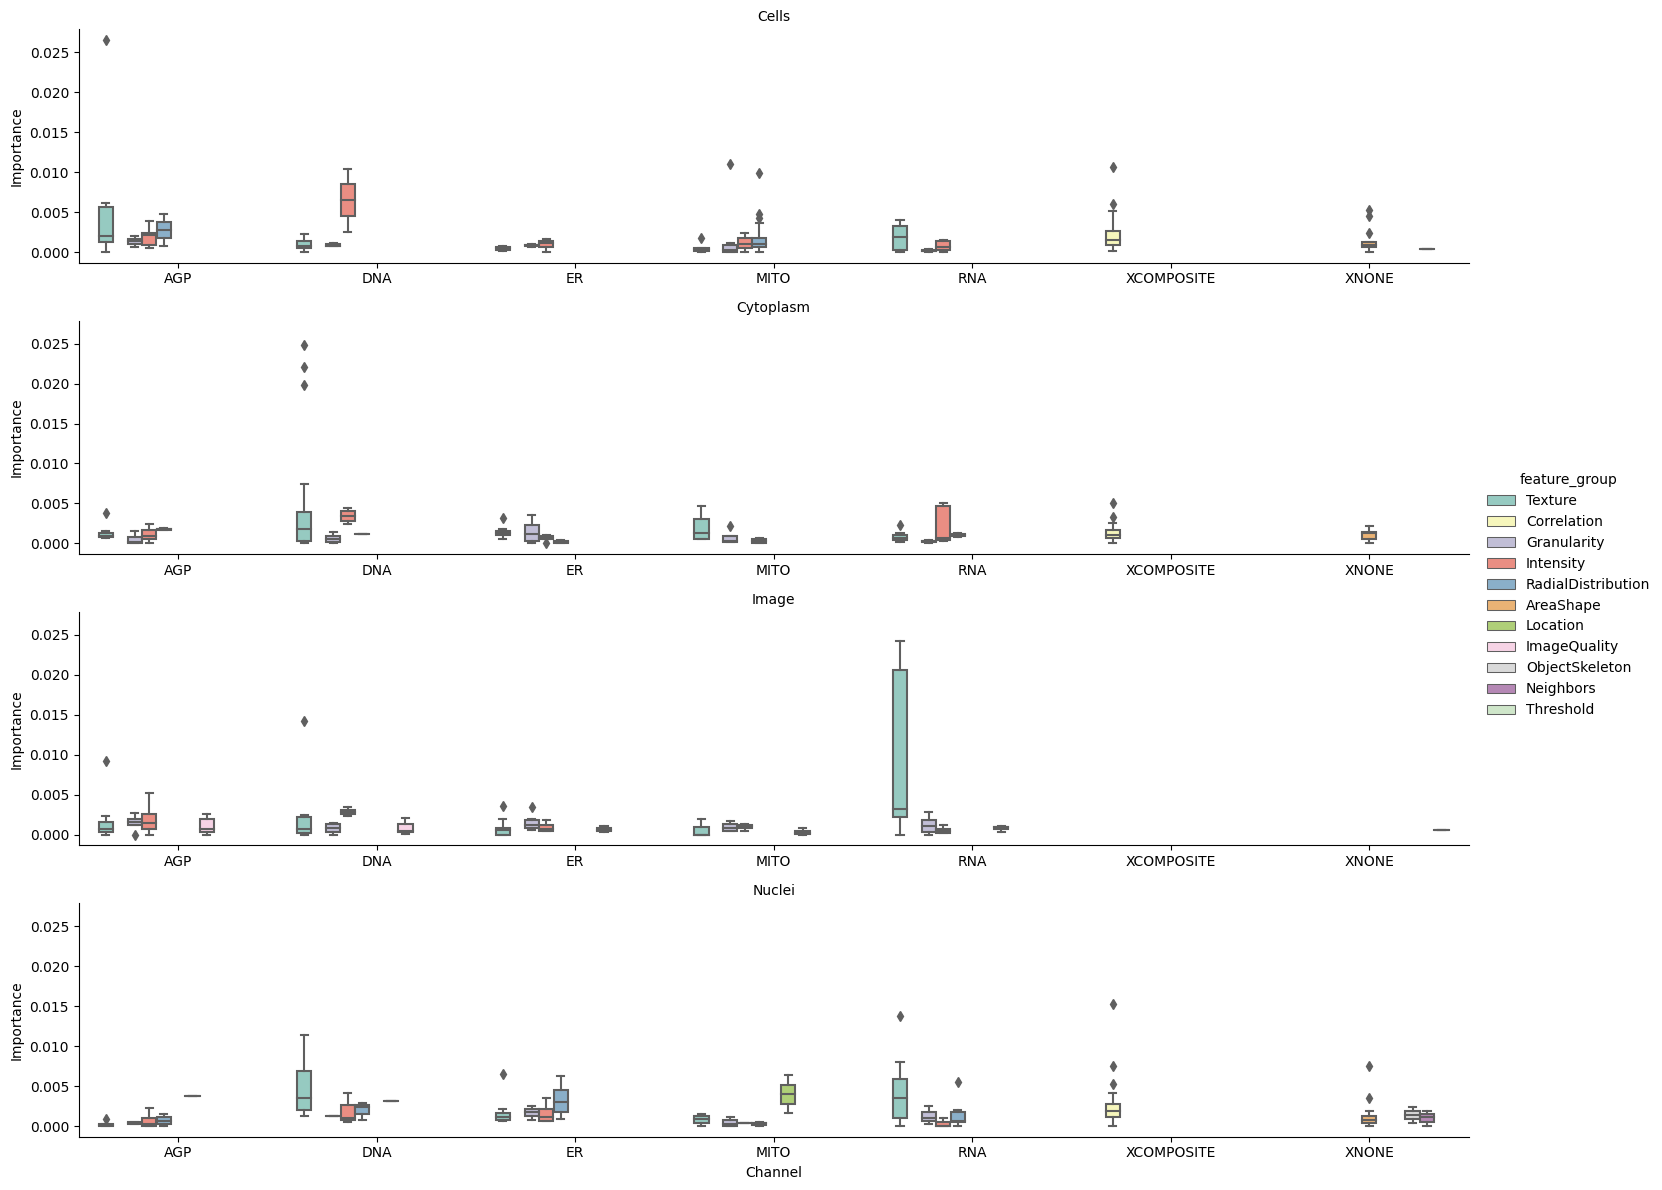

In [199]:
channel_order = sorted(selected_features_df_parsed["channel"].unique())

g = sns.catplot(
    data=selected_features_df_parsed,
    kind="box",
    x="channel",
    y="importance",
    col="compartment",
    hue="feature_group",
    order=channel_order,
    col_wrap=1,
    height=3,
    aspect=5,
    sharex=False,
    palette="Set3",  # Optional: specify a color palette
)
g.set_axis_labels("Channel", "Importance")
g.set_titles("{col_name}")

plt.show()